# Practical Machine Learning
Tutorial [video series](https://www.youtube.com/playlist?list=PLQVvvaa0QuDfKTOs3Keq_kaG2P55YRn5v) notes. Covers writing machine learning algorithms from scratch

## Stock Market Data
Use quandl to retreive data. 
- Relationship between open and close price tells you how the shares did that day.
- Adjusted prices take into account stock splits.
- Volume is how many trades occurred that day. Related to volatility

We can create new features to express relationships which can be more useful than putting in the raw features themselves.

In [115]:
import pandas as pd
import quandl
import math
import datetime
import numpy as np
import pandas as pd
import pickle
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from pylab import rcParams
rcParams['figure.figsize'] = 20, 16
plt.style.use('ggplot')

In [106]:
df = quandl.get("WIKI/GOOGL")
print(df.head())
print(df.dtypes)
print(list(df.columns.values))

              Open    High     Low    Close      Volume  Ex-Dividend  \
Date                                                                   
2004-08-19  100.01  104.06   95.96  100.335  44659000.0          0.0   
2004-08-20  101.01  109.08  100.50  108.310  22834300.0          0.0   
2004-08-23  110.76  113.48  109.05  109.400  18256100.0          0.0   
2004-08-24  111.24  111.60  103.57  104.870  15247300.0          0.0   
2004-08-25  104.76  108.00  103.88  106.000   9188600.0          0.0   

            Split Ratio  Adj. Open  Adj. High   Adj. Low  Adj. Close  \
Date                                                                   
2004-08-19          1.0  50.159839  52.191109  48.128568   50.322842   
2004-08-20          1.0  50.661387  54.708881  50.405597   54.322689   
2004-08-23          1.0  55.551482  56.915693  54.693835   54.869377   
2004-08-24          1.0  55.792225  55.972783  51.945350   52.597363   
2004-08-25          1.0  52.542193  54.167209  52.100830   53.1

In [107]:
df = df[['Adj. Open',  'Adj. High',  'Adj. Low',  'Adj. Close', 'Adj. Volume']]

# percent difference between high and low price for the day
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Close'] * 100.0
# percent change from start and end of the day
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]
print(df.head())
print(df.tail())

            Adj. Close    HL_PCT  PCT_change  Adj. Volume
Date                                                     
2004-08-19   50.322842  8.072956    0.324968   44659000.0
2004-08-20   54.322689  7.921706    7.227007   22834300.0
2004-08-23   54.869377  4.049360   -1.227880   18256100.0
2004-08-24   52.597363  7.657099   -5.726357   15247300.0
2004-08-25   53.164113  3.886792    1.183658    9188600.0
            Adj. Close    HL_PCT  PCT_change  Adj. Volume
Date                                                     
2016-11-30      775.76  2.367356   -1.690534    2243483.0
2016-12-01      764.33  3.302239   -1.826472    2851729.0
2016-12-02      764.46  1.504330    0.336002    1686840.0
2016-12-05      778.22  1.674514    1.067532    1680524.0
2016-12-06      776.18  1.540880   -0.513977    1694701.0


In [108]:
forecast_col = 'Adj. Close'
# fill missing data, will be treated as an outlier as ML algorithms don't cope well with missing values
df.fillna(-99999, inplace=True)
# number of days to predict out - 10% of the length of the df
forecast_out = int(math.ceil(0.01 * len(df)))
print(forecast_out)

# shift columns up spreadsheet in label column 10% of the time in the future
df['label'] = df[forecast_col].shift(-forecast_out)
# remove NAs from end of column after shift up
print(df.head())
print(df.tail())

31
            Adj. Close    HL_PCT  PCT_change  Adj. Volume      label
Date                                                                
2004-08-19   50.322842  8.072956    0.324968   44659000.0  67.739104
2004-08-20   54.322689  7.921706    7.227007   22834300.0  69.399229
2004-08-23   54.869377  4.049360   -1.227880   18256100.0  68.752232
2004-08-24   52.597363  7.657099   -5.726357   15247300.0  69.639972
2004-08-25   53.164113  3.886792    1.183658    9188600.0  69.078238
            Adj. Close    HL_PCT  PCT_change  Adj. Volume  label
Date                                                            
2016-11-30      775.76  2.367356   -1.690534    2243483.0    NaN
2016-12-01      764.33  3.302239   -1.826472    2851729.0    NaN
2016-12-02      764.46  1.504330    0.336002    1686840.0    NaN
2016-12-05      778.22  1.674514    1.067532    1680524.0    NaN
2016-12-06      776.18  1.540880   -0.513977    1694701.0    NaN


## Preprocessing
You can scale your data to normalise the data points. This can get good results, but you need to consider that you'll have to scale the new values alongside the original values which can take time. For predictions where time is crucial, most people tend to skip this step.

In [109]:
X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

df.dropna(inplace=True)

y = np.array(df['label'])

## Training & Testing Sets

In [110]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

## SVM & Regression

In [111]:
clf = svm.SVR(kernel='linear')
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.96747645307319641

In [112]:
clf = LinearRegression(n_jobs=4) # num threads
clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)
print(accuracy)

0.968593157976


In [113]:
# predict next 30 days of data
forecast_set = clf.predict(X_lately)
print(forecast_set, accuracy, forecast_out)

[ 840.50433334  832.4289476   826.38276532  821.1006109   821.71910741
  813.65031995  809.34034031  791.59350762  786.85912632  785.70585246
  806.76884587  816.4020986   809.04889696  779.92520723  775.80289028
  755.57878809  779.61561427  784.35434726  791.43894542  780.22093227
  790.04014869  790.04700115  783.37442385  786.18610057  789.71745395
  794.42961296  779.54788051  767.33989725  769.69173425  783.32494796
  781.03227233] 0.968593157976 31


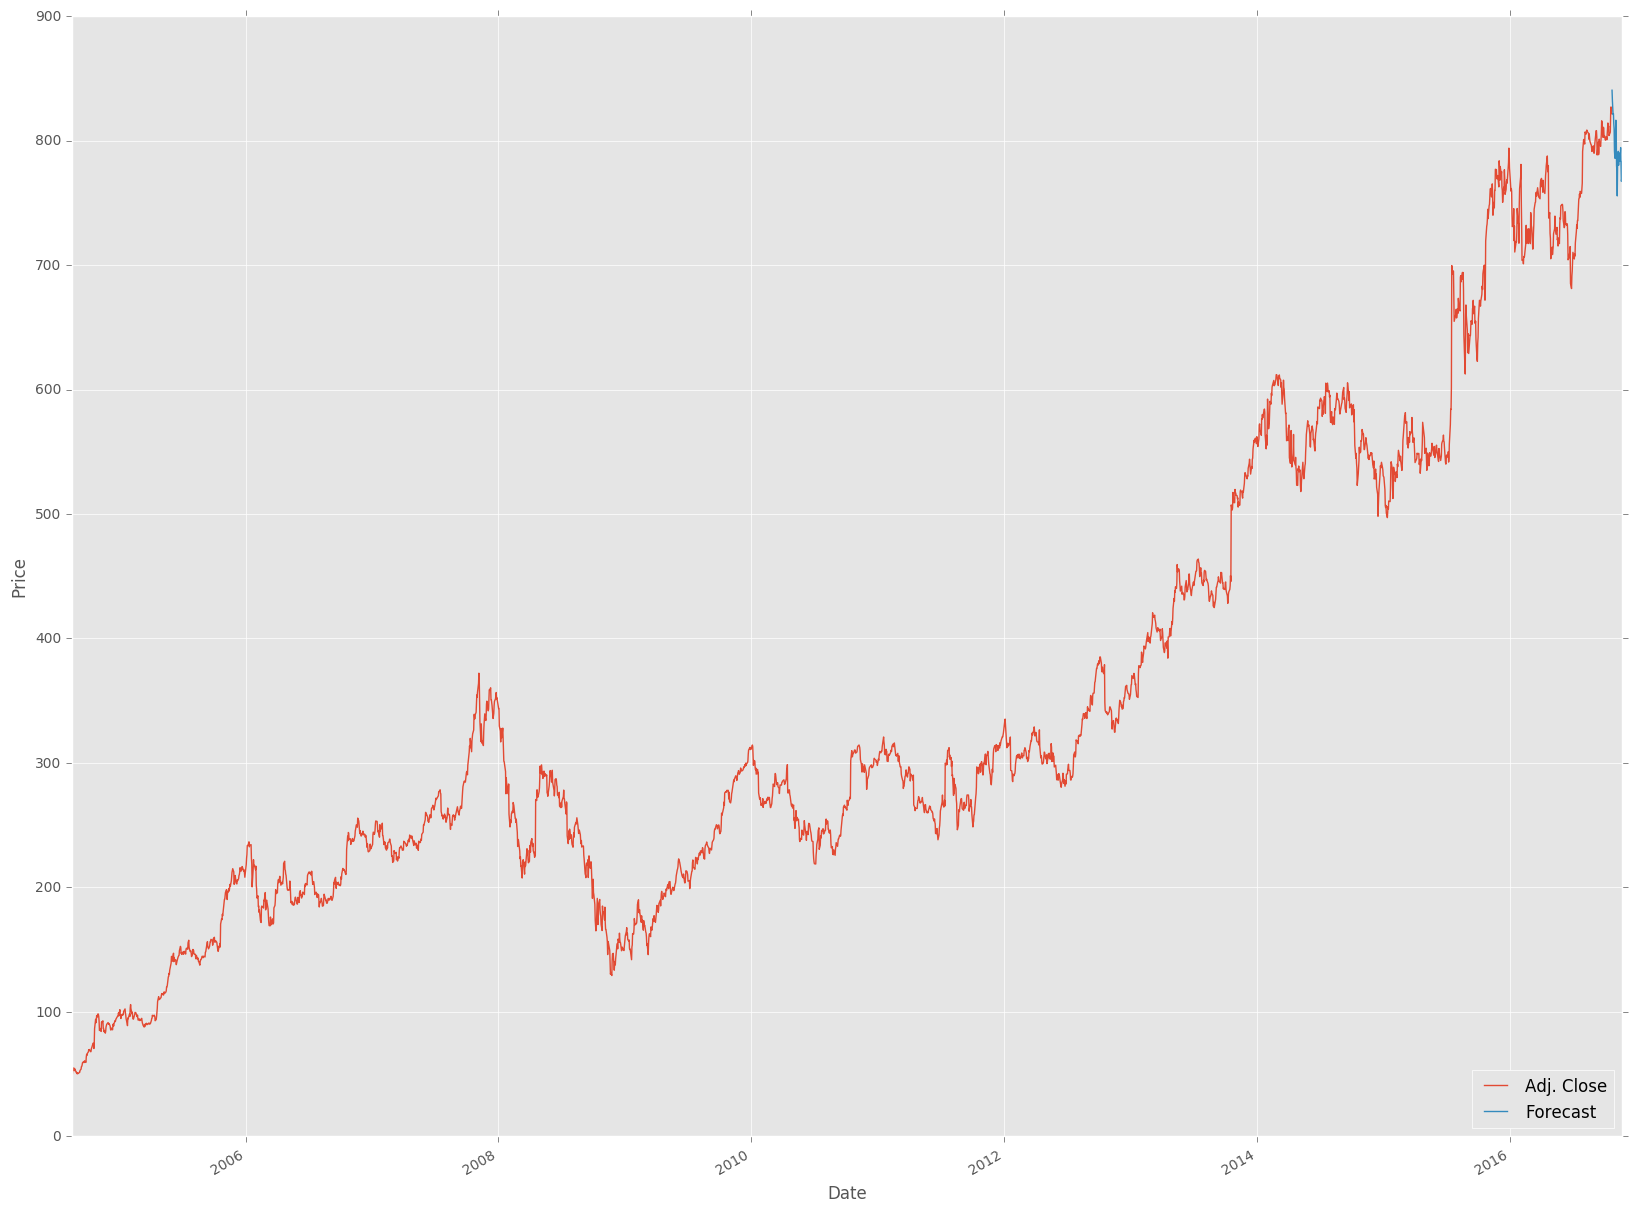

In [114]:
df['Forecast'] = np.nan
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]
    
plt.figure()
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

## Pickling Classifiers

Writing CLF
```
with open('linearregression.pickle','wb') as f:
    pickle.dump(clf, f)
```

Reading CLF
```
pickle_in = open('linearregression.pickle','rb')
clf = pickle.load(pickle_in)
```

## Implementing Regression
Regression involves quantifying the relationship between x & y variables. You'll often want to visualise the data to determine if the variables are correlated.

### Linear Equation
- $y = mx+b$
- y = predictive variable
- x = x variable value
- m = slope 
- b = y intercept

### Best Fit Slope
To identify the slope that best fits the data you multiply the mean of x by the mean of y, minus the mean of all x's times y's divided by the mean of x's squared minus the mean of x's squared minus the mean of x's squared.

$$m = \frac{\bar{x}.\bar{y} - \overline{x.y}}{(\bar{x})^2-\bar{x}^2}$$

### Best Fit Y Intercept
Intercept is the mean of the y's minus the slope multiplied by the mean of the x's

$$b = \bar{y} - m.\bar{x}$$